In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [26]:
%cd "/content/drive/MyDrive/FYPnew"

/content/drive/MyDrive/FYPnew


In [27]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils
# from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the root directory of the dataset in Google Drive
root_dir = '/content/drive/My Drive/FYPnew/Dataset'

# Categories and their paths
classes = ['NoTumor', 'Glioma', 'Meningioma', 'Pituitary']
class_directories = {
    'NoTumor': os.path.join(root_dir, 'NoTumor'),
    'Glioma': os.path.join(root_dir, 'Tumor/Glioma'),
    'Meningioma': os.path.join(root_dir, 'Tumor/Meningioma'),
    'Pituitary': os.path.join(root_dir, 'Tumor/Pituitary')
}

# Function to retrieve image file paths
def get_image_paths(directory):
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return image_files

# Populate a dictionary with class labels and their respective image file paths
files_path_dict = {cls: get_image_paths(class_directories[cls]) for cls in classes}

# Define the output directory for divided data
divided_dir = '/content/drive/My Drive/FYPnew/Divided'
train_dir = os.path.join(divided_dir, 'training')
test_dir = os.path.join(divided_dir, 'testing')

# Create necessary directories for training and testing
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")

create_dir(train_dir)
create_dir(test_dir)
for cls in classes:
    create_dir(os.path.join(train_dir, cls))
    create_dir(os.path.join(test_dir, cls))

# Function to retrieve image file paths
def get_image_paths(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Function to copy files safely
def copy_files(files, src_dir, dest_dir):
    for file in files:
        src_path = os.path.join(src_dir, file)
        dest_path = os.path.join(dest_dir, file)
        if not os.path.exists(dest_path):  # Check if file already exists
            shutil.copy(src_path, dest_path)
            print(f"Copied {file} to {dest_dir}")

# Split and copy the files
for cls in classes:
    print(f"Processing class: {cls}")
    src_dir = class_directories[cls]
    files = get_image_paths(src_dir)
    print(f"Found {len(files)} files in {cls}")
    selected_files = np.random.choice(files, int(len(files) * 0.4), replace=False)  # Select 40% of files
    print(f"Selected {len(selected_files)} files for processing from {cls}")
    train_files, test_files = train_test_split(selected_files, test_size=0.35)
    print(f"Split into {len(train_files)} training and {len(test_files)} testing files for class {cls}")

    # Copy the files to new locations
    copy_files(train_files, src_dir, os.path.join(train_dir, cls))
    copy_files(test_files, src_dir, os.path.join(test_dir, cls))

print("All processing complete! Data is ready.")

Processing class: NoTumor
Found 3066 files in NoTumor
Selected 1226 files for processing from NoTumor
Split into 796 training and 430 testing files for class NoTumor
Processing class: Glioma
Found 6307 files in Glioma
Selected 2522 files for processing from Glioma
Split into 1639 training and 883 testing files for class Glioma
Processing class: Meningioma
Found 6391 files in Meningioma
Selected 2556 files for processing from Meningioma
Split into 1661 training and 895 testing files for class Meningioma
Processing class: Pituitary
Found 5908 files in Pituitary
Selected 2363 files for processing from Pituitary
Split into 1535 training and 828 testing files for class Pituitary
All processing complete! Data is ready.


In [33]:
# Visualize some images for each class
# plt.figure(figsize=(17, 17))
# index = 0
# for cls in classes:
#     # Shuffle and select the first 4 images of each class
#     path_list = files_path_dict[cls]
#     random.shuffle(path_list)
#     selected_images = path_list[:4]

#     for img_path in selected_images:
#         index += 1
#         plt.subplot(4, 4, index)
#         img = load_img(img_path)
#         plt.imshow(img)
#         plt.title(cls)
#         plt.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np

root_dir = '/content/drive/My Drive/FYPnew/Dataset'
classes = ['NoTumor', 'Glioma', 'Meningioma', 'Pituitary']

# Output base directories
train_dir = '/content/drive/My Drive/FYPnew/Divided/training'
test_dir = '/content/drive/My Drive/FYPnew/Divided/testing'


In [ ]:
#specify directory
train_dir = '/content/drive/MyDrive/FYPnew/Divided/testing'
test_dir = '/content/drive/MyDrive/FYPnew/Divided/training'

In [ ]:
classes = os.listdir('/content/drive/MyDrive/FYPnew/Divided/training')

In [ ]:
classes

['NoTumor', 'Glioma', 'Meningioma', 'Pituitary']

In [ ]:
files_path_dict = {}

for c in classes:
  # Correctly use os.path.join to construct the file paths
  files_path_dict[c] = [os.path.join(train_dir, c, x) for x in os.listdir(os.path.join(train_dir, c))]

In [ ]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir('/content/drive/MyDrive/FYPnew/Divided/training'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/FYPnew/Divided/training', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in NoTumor = 796 

Number of images in Glioma = 1639 

Number of images in Meningioma = 1661 

Number of images in Pituitary = 1535 


In [ ]:
#use Image Data Generator to perform the task
#train set
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

#training
train_data = datagen.flow_from_directory('/content/drive/MyDrive/FYPnew/Divided/training',
                                         target_size=(240, 240),
                                         batch_size=64,
                                         class_mode='categorical',
                                         subset='training')

#validation
valid_data = datagen.flow_from_directory('/content/drive/MyDrive/FYPnew/Divided/training',
                                         target_size=(240, 240),
                                         batch_size=64,
                                         class_mode='categorical',
                                         subset='validation')

#test set
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/drive/MyDrive/FYPnew/Divided/testing',
                                         target_size=(240, 240),
                                        class_mode='categorical',
                                        shuffle=False)

Found 4506 images belonging to 4 classes.
Found 1125 images belonging to 4 classes.
Found 3036 images belonging to 4 classes.


In [ ]:
#view the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'Glioma': 0, 'Meningioma': 1, 'NoTumor': 2, 'Pituitary': 3}
{'Glioma': 0, 'Meningioma': 1, 'NoTumor': 2, 'Pituitary': 3}


In [2]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Constants
N_TYPES = 4  # Number of classes
SEED = 42  # Seed for reproducibility

# Load EfficientNetB1 without the top layer and set input shape
intepreterCNN = EfficientNetB1(include_top=False, input_shape=(240, 240, 3), weights='imagenet')

# Freeze all layers in the base model
for layer in intepreterCNN.layers:
    layer.trainable = False

# Adding custom layers to the base model
intepreter_model = intepreterCNN.output
intepreter_model = GlobalAveragePooling2D(name='global_avg_pooling')(intepreter_model)
intepreter_model = Dense(512, activation='relu', name='dense_layer1')(intepreter_model)
intepreter_model = Dropout(0.5, seed=SEED, name='dropout_layer')(intepreter_model)
predictions = Dense(N_TYPES, activation='softmax', name='output_layer')(intepreter_model)

# Create the actual model
intepreter_model = Model(inputs=intepreterCNN.input, outputs=predictions)

# Compile the model
intepreter_model.compile(optimizer=Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Display the model summary
intepreter_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 240, 240, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 240, 240, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 240, 240, 3)          0         ['normalization_2[0][0]'

In [ ]:
# Define your callbacks
checkpoint = ModelCheckpoint('XAI2.h5', monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

In [ ]:
# Assume train_data and valid_data have been previously defined
history = intepreter_model.fit(
    train_data,
    epochs=15,
    validation_data=valid_data,
    verbose=1,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

Epoch 1/15
71/71 [==============================] - ETA: 0s - loss: 0.7914 - accuracy: 0.6957 
Epoch 1: val_accuracy improved from -inf to 0.80356, saving model to XAI2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 2160s 29s/step - loss: 0.7914 - accuracy: 0.6957 - val_loss: 0.4776 - val_accuracy: 0.8036 - lr: 1.0000e-04
Epoch 2/15
71/71 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9217
Epoch 2: val_accuracy improved from 0.80356 to 0.91022, saving model to XAI2.h5
71/71 [==============================] - 134s 2s/step - loss: 0.2381 - accuracy: 0.9217 - val_loss: 0.2547 - val_accuracy: 0.9102 - lr: 1.0000e-04
Epoch 3/15
71/71 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.9716
Epoch 3: val_accuracy improved from 0.91022 to 0.92978, saving model to XAI2.h5
71/71 [==============================] - 144s 2s/step - loss: 0.1008 - accuracy: 0.9716 - val_loss: 0.1911 - val_accuracy: 0.9298 - lr: 1.0000e-04
Epoch 4/15
71/71 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9867
Epoch 4: val_accuracy improved from 0.92978 to 0.93244, saving model to XAI2.h5
71/71 [============================

In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained model
model_path = '/content/drive/MyDrive/FYPnew/XAI2.h5'  # Update this path to the location of your .h5 file
model = load_model(model_path)

# Path to your test data directory
test_data_dir = '/content/drive/MyDrive/FYPnew/Divided/testing'

# Initialize the test data generator
test_datagen = ImageDataGenerator()

# Prepare data flow from directory
test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Set to False to maintain the data order for later comparison and confusion matrix analysis
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 3036 images belonging to 4 classes.
48/48 [==============================] - 18s 330ms/step - loss: 0.3309 - accuracy: 0.9315
Test Loss: 0.3309
Test Accuracy: 93.15%


Found 3036 images belonging to 4 classes.
48/48 [==============================] - 18s 330ms/step


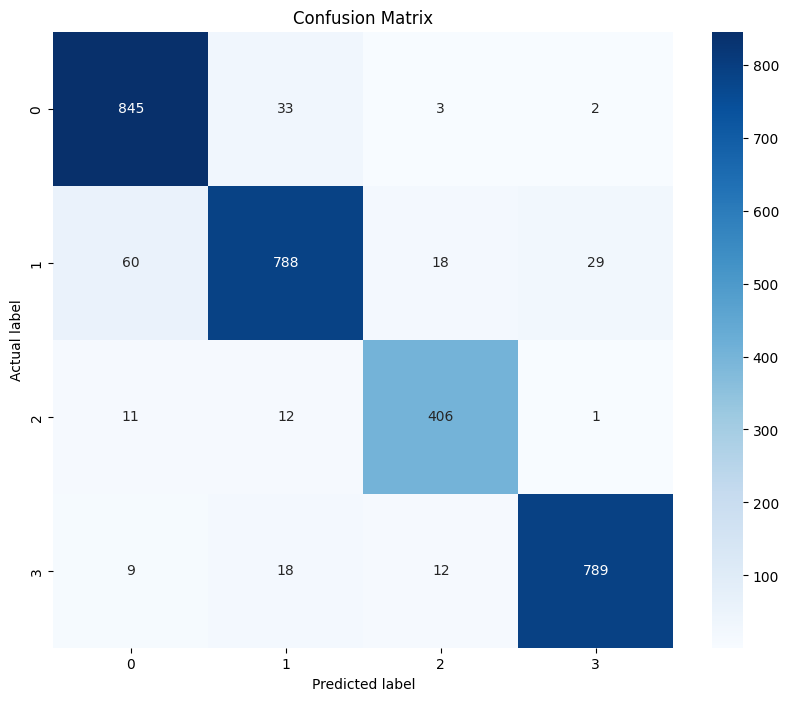

In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the pre-trained model
model_path = '/content/drive/MyDrive/FYPnew/XAI2.h5'
model = load_model(model_path)

# Path to your test data directory
test_data_dir = '/content/drive/MyDrive/FYPnew/Divided/testing'

# Initialize the test data generator
test_datagen = ImageDataGenerator()

# Prepare data flow from directory
test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Get the ground truth of your data.
test_data.reset()  # reset the generator to avoid shuffling
y_true = test_data.classes

# Predict the data
predictions = model.predict(test_data, steps=test_data.n//test_data.batch_size+1)
y_pred = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
# from tensorflow.keras.applications import EfficientNetB1
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# # Constants
# N_TYPES = 4  # Number of classes
# SEED = 42  # Seed for reproducibility

# intepreterCNN = EfficientNetB1(include_top=False, input_shape=(240, 240, 3), weights='imagenet')

# # Freeze all layers in the base model
# for layer in intepreterCNN.layers:
#     layer.trainable = False

# # Adding custom layers to the base model
# intepreter_model = intepreterCNN.output
# intepreter_model = GlobalAveragePooling2D(name='global_avg_pooling')(intepreter_model) # reduce spatial dimensions of the output
# intepreter_model = Dense(512, activation='relu', name='dense_layer1')(intepreter_model)
# intepreter_model = Dropout(0.5, seed=SEED, name='dropout_layer')(intepreter_model)
# predictions = Dense(N_TYPES, activation='softmax', name='output_layer')(intepreter_model)

# # Create the actual model
# intepreter_model = Model(inputs=intepreterCNN.input, outputs=predictions) # combine the base model and the custom layers

# # Compile the model
# intepreter_model.compile(optimizer=Adam(learning_rate=0.0001),
#                          loss='categorical_crossentropy',
#                          metrics=['accuracy'])

# # Display the model summary
# intepreter_model.summary()